---
### Python library load
---

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(),".."))

In [2]:
#------------------------------------------------------------
## Python library Load 
#------------------------------------------------------------
%pylab inline
import pandas as pd
import numpy as np
import seaborn; seaborn.set_style('whitegrid')
import logging, copy, time, pickle, os
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# pytorch module load
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data_utils

import torchvision
from torchvision import datasets, models, transforms


# data / models / images dir생성
print("Current path is {}".format(os.getcwd()))
    
if not os.path.exists(os.path.join(os.getcwd(), 'models')):
    os.makedirs(os.path.join(os.getcwd(), 'models'))
    
if not os.path.exists(os.path.join(os.getcwd(), 'images')):
    os.makedirs(os.path.join(os.getcwd(), 'images'))   

Populating the interactive namespace from numpy and matplotlib
Current path is /home/ubuntu/notebooks/pytorch/03_deep_mf


---
### Contents
---

- 1) Building Matrix Factorization with Pytorch
- 2) Building Deep Matrix Factorization

---
### 0) Load the movielens dataset and simple EDA
---

In [3]:
from utils.datasets import movielens
dataset_nm = 'ml-latest-small'
data_dir = 'dataset_down'
movielens.download_unzip(dataset_nm, data_dir)

downloaded filesize is 0.93 mb
downloaded files : {'ml-latest-small.zip', 'ratings.csv', 'movies.csv'}


In [4]:
data = pd.read_csv('./{}/{}/ratings.csv'.format(data_dir,dataset_nm),sep=",", engine = 'python', usecols=(0, 1, 2))
data.columns = ['userID','movieID','ratings']
print(data.head())
print(data.shape)

   userID  movieID  ratings
0       1        1      4.0
1       1        3      4.0
2       1        6      4.0
3       1       47      5.0
4       1       50      5.0
(100836, 3)


In [5]:
print("Min value of rating : {}".format(data.ratings.min(axis=0)))
print("Max value of rating : {}".format(data.ratings.max(axis=0)))

Min value of rating : 0.5
Max value of rating : 5.0


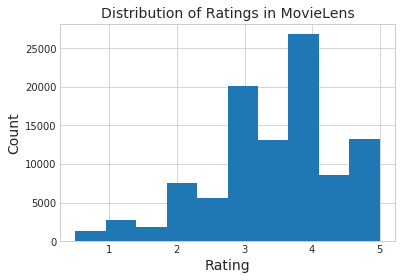

In [6]:
plt.figure(facecolor='w')
plt.hist(data['ratings'])
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Ratings in MovieLens", fontsize=14)
plt.show()

In [7]:
print("user id min/max: ", data['userID'].min(), data['userID'].max())
print("# unique users: ", numpy.unique(data['userID']).shape[0])
print("")
print("movie id min/max: ", data['movieID'].min(), data['movieID'].max())
print("# unique movies: ", numpy.unique(data['movieID']).shape[0])

user id min/max:  1 610
# unique users:  610

movie id min/max:  1 193609
# unique movies:  9724


In [8]:
# random shuffling
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,userID,movieID,ratings
0,76,81535,4.5
1,39,364,4.0
2,534,101864,4.0
3,64,1645,2.5
4,608,2167,4.0


---
### 1) Building Matrix Factorization with PyTorch
- building matrix factorization model using PyTorch
- that is, used embedding layer to build latent variable and dot product to compute recomm. scores by PyTorch operation
- PyTorch building
  * Latent Variable -> torch.nn.Embedding() Layer
  * dot Product -> torch.sum(user_embedding_values  item_embedding_values*, 1),  matrix muplication with column-wise summation
---

#### (0) preprocess dataset

In [9]:
users = data['userID'].tolist()
movies = data['movieID'].tolist()
ratings = data['ratings'].tolist()

# unique index for users and movies (to be used in embedding layers)
users_ind = data['userID'].astype('category').cat.codes.tolist()
movies_ind = data['movieID'].astype('category').cat.codes.tolist()

user_ind_mapping = pd.DataFrame({'userID':users, 'userID_ind':users_ind}).drop_duplicates()
movie_ind_mapping = pd.DataFrame({'movieID':movies, 'movieID_ind':movies_ind}).drop_duplicates()

print(user_ind_mapping.shape)
print(movie_ind_mapping.shape)

n_users, n_movies = len(set(users)), len(set(movies))

(610, 2)
(9724, 2)


In [10]:
# find the size of embeddling layers input
train_size = int(len(users)*.9) # 90% train_set, 10% valid_set
batch_size = 15000

# split test and train data set (100,000 for test vs remaining for training)
train_dataset = data_utils.TensorDataset(torch.tensor(users_ind[train_size:], dtype = torch.long), torch.tensor(movies_ind[train_size:], dtype = torch.long), torch.tensor(ratings[train_size:], dtype = torch.float32))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=30)

test_dataset = data_utils.TensorDataset(torch.tensor(users_ind[:train_size], dtype = torch.long), torch.tensor(movies_ind[:train_size], dtype = torch.long), torch.tensor(ratings[:train_size], dtype = torch.float32))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=True, num_workers=1)    

In [11]:
# set gpu mode
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


#### (1) build (Vanilla) Matrix Factorization model

In [12]:
class Vanilla_MF(nn.Module):
    def __init__(self, user_n, item_n, latent_dim):
        super(Vanilla_MF, self).__init__()
        
        self.user = nn.Embedding(num_embeddings=user_n, embedding_dim=latent_dim) # user dim x embedding dim
        self.item = nn.Embedding(num_embeddings=item_n, embedding_dim=latent_dim) # output dim x embedding dim
        
    def forward(self, user_i, item_i):
        # embedding values of user & item
        user_e = self.user(user_i)
        item_e = self.item(item_i)
        
        # rating value of user_i & item_i
        pred = torch.sum(user_e*item_e, 1) # prediction values
        reg_loss = torch.sum(torch.sum(user_e*user_e,1)) + torch.sum(torch.sum(item_e*item_e,1)) # regularization l2 losses
        
        return pred, reg_loss

- loss function (ref. http://yifanhu.net/PUB/cf.pdf)

<img src="./images/loss_fn_1.png" width="400" align="left"/>

<br/>

In [13]:
## Input Args.
n_users = n_users
n_items = n_movies
n_factor = 25 # dimension of latent variable 

reg_v = 0.3

learning_rate = 1e-4
weight_decay = 1e-5

In [14]:
# model build
model = Vanilla_MF(n_users, n_items, n_factor)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = True

model

Vanilla_MF(
  (user): Embedding(610, 25)
  (item): Embedding(9724, 25)
)

In [15]:
 # Loss function & Optimizer
mse_loss_fn = nn.MSELoss()
opt_fn = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

In [16]:
def train_model(model, train_loader, test_loader, reg_v, num_epochs = 30):
    print("Running on {}".format(device))
    print("batch size is {:,}".format(train_loader.batch_size))
    start_t = time.time()

    train_loss = []
    test_loss = []    
    
    for epoch in range(num_epochs):
        model.train() # set model to training mode
        
        total_running_loss = 0.0
        mse_running_loss = 0.0
        
        # for training
        i = 0
        iter_cnt = 0
        for user, item, rating in train_loader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device)
            
            batch_size = user.size(0)

            # (0) zero grads
            opt_fn.zero_grad()

            # (1) forward + loss calculation
            preds, reg_loss = model(user, item)
            mse_loss = mse_loss_fn(preds.squeeze(), rating)
            loss = mse_loss + reg_v*reg_loss/batch_size
            
            # (2) backward + optimize
            loss.backward()  # calculate gradients with embedded autograd fn of pytorch
            for i in range(user.size(0)):
                opt_fn.step()

            # result(loss) summary
            total_running_loss += loss.item()*batch_size # loss.item() is the mean of total losses of mini-batch. So, multiply mini-batch
            mse_running_loss += mse_loss.item()*batch_size
            i += 1
            iter_cnt += batch_size
            
        epoch_loss = total_running_loss / iter_cnt     
        epoch_mse_loss = mse_running_loss / iter_cnt     
        train_loss.append((epoch, epoch_loss, epoch_mse_loss))
        
        
        # for validation        
        model.eval()
        mse_running_loss = 0.0        
        
        i = 0
        iter_cnt = 0
        for user, item, rating in test_loader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device)           
            
            batch_size = user.size(0)
            
            # (1) forward + loss calculation
            with torch.no_grad():
#                 preds, reg_loss = model(user, item)
                preds, _ = model(user, item)
                loss = mse_loss_fn(preds.squeeze(), rating)
            
            # result(loss) summary
            mse_running_loss += loss.item()*batch_size # loss.item() is the mean of total losses of mini-batch. So, multiply mini-batch
            i += 1
            iter_cnt += batch_size
            
        mse_epoch_loss = mse_running_loss / iter_cnt     
        test_loss.append((epoch, mse_epoch_loss))
            
        print('Epoch {} / {} [Train] Total loss {:.4f}, MSE Loss: {:.4f}, [Test] MSE Loss: {:.4f}, running time : {:.1f} sec '.format(epoch + 1, num_epochs, train_loss[epoch][1], train_loss[epoch][2], test_loss[epoch][1], time.time()-start_t))
        print('-'*20)
        
    print("total elapsed time is {:.1f}sec".format(time.time()-start_t))
    torch.cuda.empty_cache()
    return model

In [17]:
model = train_model(model, train_loader, test_loader, reg_v, num_epochs=20)

Running on cuda:0
batch size is 15,000
Epoch 1 / 20 [Train] Total loss 52.1385, MSE Loss: 37.4107, [Test] MSE Loss: 13.8632, running time : 4.5 sec 
--------------------
Epoch 2 / 20 [Train] Total loss 16.2265, MSE Loss: 13.9709, [Test] MSE Loss: 13.4297, running time : 9.0 sec 
--------------------
Epoch 3 / 20 [Train] Total loss 14.4422, MSE Loss: 13.5175, [Test] MSE Loss: 13.3551, running time : 13.5 sec 
--------------------
Epoch 4 / 20 [Train] Total loss 13.7416, MSE Loss: 13.4079, [Test] MSE Loss: 13.3445, running time : 17.9 sec 
--------------------
Epoch 5 / 20 [Train] Total loss 13.5402, MSE Loss: 13.3901, [Test] MSE Loss: 13.3431, running time : 22.4 sec 
--------------------
Epoch 6 / 20 [Train] Total loss 13.4630, MSE Loss: 13.3912, [Test] MSE Loss: 13.3434, running time : 26.8 sec 
--------------------
Epoch 7 / 20 [Train] Total loss 13.4336, MSE Loss: 13.3884, [Test] MSE Loss: 13.3433, running time : 31.3 sec 
--------------------
Epoch 8 / 20 [Train] Total loss 13.4211

In [18]:
# valinla MF with bias
class Vanilla_MF_w_bias(nn.Module):
    def __init__(self, user_n, item_n, user_latent_n, item_latent_n, mean_v):
        super(Vanilla_MF_w_bias, self).__init__()
        
        self.user = nn.Embedding(num_embeddings=user_n, embedding_dim=user_latent_n) # user dim x embedding dim
        self.user_bias = nn.Embedding(num_embeddings=user_n, embedding_dim=1)
        
        self.item = nn.Embedding(num_embeddings=item_n, embedding_dim=item_latent_n) # output dim x embedding dim
        self.item_bias = nn.Embedding(num_embeddings=item_n, embedding_dim=1) # output dim x embedding dim
        
        self.mean_v = mean_v
        
    def forward(self, user_i, item_i):
        # embedding values of user & item
        user_e = self.user(user_i)
        user_b = self.user_bias(user_i).squeeze()
        
        item_e = self.item(item_i)
        item_b = self.item_bias(item_i).squeeze()
        
        # rating value of user_i & item_i
        preds = torch.sum(user_e*item_e, 1)
        preds = preds + user_b + item_b
        preds = preds + self.mean_v
        
        reg_loss = torch.sum(torch.sum(user_e*user_e,1)) + torch.sum(torch.sum(item_e*item_e,1)) # l2 losses
        
        return preds, reg_loss

In [19]:
## Input Args.
n_users = n_users
n_items = n_movies
n_factor = 25 # dimentions of latent variable
reg_v = 0.3

learning_rate = 1e-4
weight_decay = 1e-5

# 전체 스코어 평균값 계산
mean_v = torch.tensor(np.mean(ratings[train_size:])).to(device)
mean_v = np.mean(ratings)

model = Vanilla_MF_w_bias(n_users, n_items, n_factor, n_factor, mean_v)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = True

In [20]:
## params
mse_loss_fn = nn.MSELoss()
opt_fn = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

In [21]:
model = train_model(model, train_loader, test_loader, reg_v, num_epochs=20)

Running on cuda:0
batch size is 15,000
Epoch 1 / 20 [Train] Total loss 43.0318, MSE Loss: 27.9549, [Test] MSE Loss: 1.8935, running time : 6.6 sec 
--------------------
Epoch 2 / 20 [Train] Total loss 4.2412, MSE Loss: 1.9372, [Test] MSE Loss: 1.3029, running time : 13.4 sec 
--------------------
Epoch 3 / 20 [Train] Total loss 2.2217, MSE Loss: 1.3163, [Test] MSE Loss: 1.1438, running time : 20.0 sec 
--------------------
Epoch 4 / 20 [Train] Total loss 1.4373, MSE Loss: 1.1374, [Test] MSE Loss: 1.1320, running time : 26.8 sec 
--------------------
Epoch 5 / 20 [Train] Total loss 1.2548, MSE Loss: 1.1283, [Test] MSE Loss: 1.1188, running time : 33.7 sec 
--------------------
Epoch 6 / 20 [Train] Total loss 1.1704, MSE Loss: 1.1074, [Test] MSE Loss: 1.1246, running time : 40.5 sec 
--------------------
Epoch 7 / 20 [Train] Total loss 1.1595, MSE Loss: 1.1195, [Test] MSE Loss: 1.1125, running time : 47.1 sec 
--------------------
Epoch 8 / 20 [Train] Total loss 1.1272, MSE Loss: 1.0981,

---
### 2) Building Deep Matrix Factorization
- To build the relationship of Users and Moview in a non-linear model, Used the Neural Network(NN) architecture
- For buildng deep Matrix Facotrization using PyTorch
  * Latent Variable -> torch.nn.Embedding() Layer
  * forward & backword path between NN layers could be built on non-linear activation functions like sigmoid / relu
---

In [22]:
class deep_MF(nn.Module):
    def __init__(self, user_n, item_n, emb_d1, emb_d2):
        super(deep_MF, self).__init__()        
        # params
        self.user_n = int(user_n)
        self.item_n = int(item_n)
        self.emb_d1 = int(emb_d1)    
        self.emb_d2 = int(emb_d2)      
        
        # embedding layers
        self.user_ly = nn.Embedding(num_embeddings=user_n, embedding_dim=emb_d1) # input dim x embedding dim (25 latent vars)
        self.item_ly = nn.Embedding(num_embeddings=item_n, embedding_dim=emb_d2) # output dim x embedding dim (25 latent vars)
        
        # fully connected-layers
        self.fc1 = nn.Linear((self.emb_d1 + self.emb_d2), 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        
        self.batch_norm = nn.BatchNorm1d(64)
        
        
    def forward(self, user_i, item_i):
        # user & item embeddings 
        user_e = self.user_ly(user_i)
        item_e = self.item_ly(item_i)
        
        # cocnat two embedding vectors and flatten
        concat_t = torch.cat((user_e, item_e),1)
        flat_t = concat_t.view(concat_t.size(0),-1)
        
        # add fully-connected layers
        out_fc1 = self.batch_norm(F.relu(self.fc1(flat_t)))
        out_fc2 = self.batch_norm(F.relu(self.fc2(out_fc1)))
        out = self.fc3(out_fc2)
        
        return out, 1

In [23]:
## Input Args.
n_users = n_users
n_items = n_movies
n_factor = 25

learning_rate = 1e-3
weight_decay = 1e-5

model = deep_MF(n_users, n_items, n_factor, n_factor)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = True
    
model

deep_MF(
  (user_ly): Embedding(610, 25)
  (item_ly): Embedding(9724, 25)
  (fc1): Linear(in_features=50, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [24]:
## params
mse_loss_fn = nn.MSELoss()
opt_fn = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

In [26]:
def train_model(model, train_loader, test_loader, num_epochs = 30):
    print("Running on {}".format(device))
    print("batch size is {:,}".format(train_loader.batch_size))
    start_t = time.time()

    train_loss = []
    test_loss = []    
    
    for epoch in range(num_epochs):
        model.train() # set model to training mode
        running_loss = 0.0
        
        # for training
        i = 0
        iter_cnt = 0
        for user, item, rating in train_loader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device)
            
            batch_size = user.size(0)

            # (0) zero grads
            opt_fn.zero_grad()

            # (1) forward + loss calculation
            preds, _ = model(user, item)
            loss = mse_loss_fn(preds.squeeze(), rating)

            # (2) backward + optimize
            loss.backward()  # calculate gradients with embedded autograd fn of pytorch
            for i in range(10):
                opt_fn.step()

            # result(loss) summary
            running_loss += loss.item()*batch_size # loss.item() is the mean of total losses of mini-batch. So, multiply mini-batch
            i += 1
            iter_cnt += batch_size
            
        epoch_loss = running_loss / iter_cnt     
        train_loss.append((epoch, epoch_loss, 'loss'))
        
        
        # for validation        
        model.eval()
        running_loss = 0.0        
        
        i = 0
        iter_cnt = 0
        for user, item, rating in test_loader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device)           
            
            batch_size = user.size(0)
            
            # (1) forward + loss calculation
            with torch.no_grad():
                preds, _ = model(user, item)
                loss = mse_loss_fn(preds.squeeze(), rating)
            
            # result(loss) summary
            running_loss += loss.item()*batch_size # loss.item() is the mean of total losses of mini-batch. So, multiply mini-batch
            i += 1
            iter_cnt += batch_size
            
        epoch_loss = running_loss / iter_cnt     
        test_loss.append((epoch, epoch_loss, 'loss'))
            
        print('Epoch {} / {} [Train] MSE Loss: {:.4f}, [Test] MSE Loss: {:.4f}, running time : {:.1f} sec '.format(epoch + 1, num_epochs, train_loss[epoch][1],test_loss[epoch][1], time.time()-start_t))
        print('-'*20)
        
    print("total elapsed time is {:.1f}sec".format(time.time()-start_t))
    torch.cuda.empty_cache()
    return model

In [27]:
 model = train_model(model, train_loader, test_loader, num_epochs = 30)

Running on cuda:0
batch size is 15,000
Epoch 1 / 30 [Train] MSE Loss: 14.1389, [Test] MSE Loss: 13.7342, running time : 2.3 sec 
--------------------
Epoch 2 / 30 [Train] MSE Loss: 13.7006, [Test] MSE Loss: 13.4318, running time : 4.6 sec 
--------------------
Epoch 3 / 30 [Train] MSE Loss: 13.3001, [Test] MSE Loss: 13.0488, running time : 6.9 sec 
--------------------
Epoch 4 / 30 [Train] MSE Loss: 12.7751, [Test] MSE Loss: 12.4966, running time : 9.3 sec 
--------------------
Epoch 5 / 30 [Train] MSE Loss: 12.1159, [Test] MSE Loss: 11.7389, running time : 11.5 sec 
--------------------
Epoch 6 / 30 [Train] MSE Loss: 11.3172, [Test] MSE Loss: 10.8723, running time : 13.9 sec 
--------------------
Epoch 7 / 30 [Train] MSE Loss: 10.3771, [Test] MSE Loss: 9.9154, running time : 16.2 sec 
--------------------
Epoch 8 / 30 [Train] MSE Loss: 9.3202, [Test] MSE Loss: 8.7381, running time : 18.5 sec 
--------------------
Epoch 9 / 30 [Train] MSE Loss: 8.1909, [Test] MSE Loss: 7.6694, running 